传入库

In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import graphviz
import os


from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math, Image

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import PartialDependenceDisplay,partial_dependence


%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

读取输出数据

In [3]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = '.', 
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        float64
Age (day)                                                  int64
Concrete compressive strength(MPa, megapascals)          float64
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)

In [5]:
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
label_column = 'Concrete compressive strength(MPa, megapascals)'
feature_columns = [c for c in concrete_df.columns if c != label_column]
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      ", and the response variable is:", label_column)

Features are: ['Cement (component 1)(kg in a m^3 mixture)', 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 'Fly Ash (component 3)(kg in a m^3 mixture)', 'Water  (component 4)(kg in a m^3 mixture)', 'Superplasticizer (component 5)(kg in a m^3 mixture)', 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)'] , and the response variable is: Concrete compressive strength(MPa, megapascals)


特征缩放（标准化）

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]],
      shape=(1030, 8))

目标值的分布情况

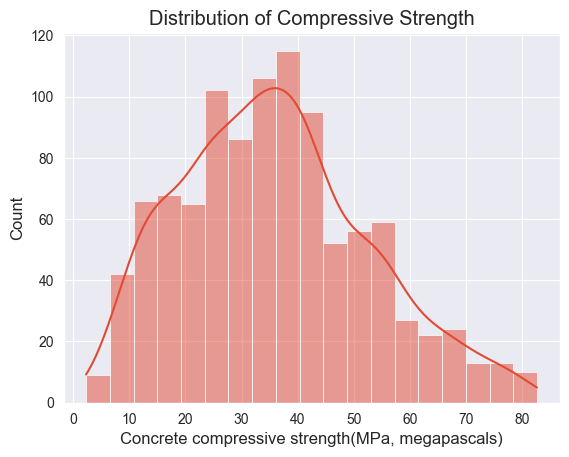

In [7]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

相关性计算

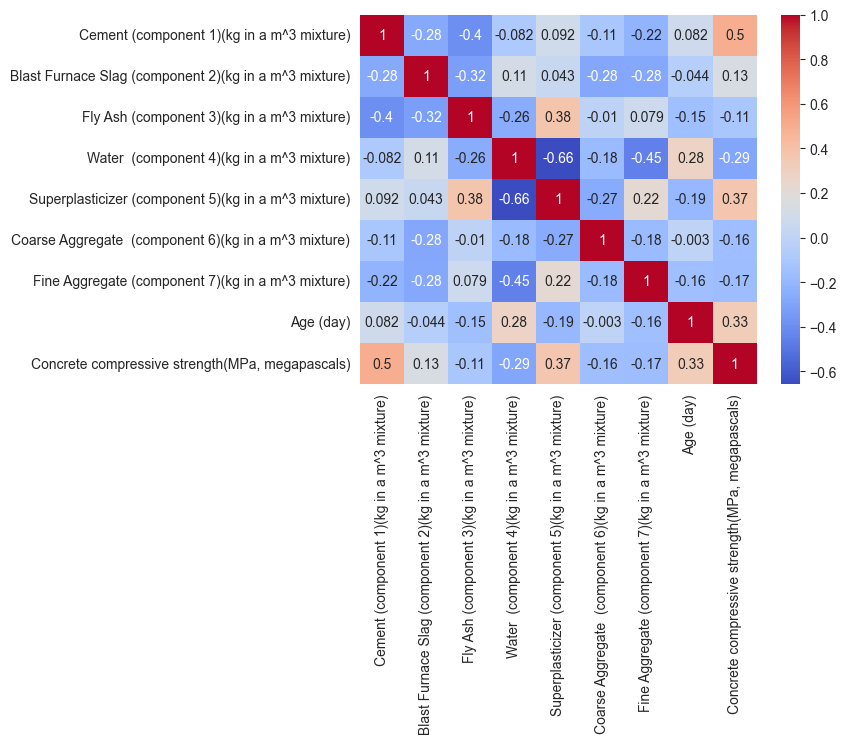

In [8]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

多重共线性VIF

In [9]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement (component 1)(kg in a m^3 mixture) 15.457
Blast Furnace Slag (component 2)(kg in a m^3 mixture) 3.329
Fly Ash (component 3)(kg in a m^3 mixture) 4.148
Water  (component 4)(kg in a m^3 mixture) 82.158
Superplasticizer (component 5)(kg in a m^3 mixture) 5.471
Coarse Aggregate  (component 6)(kg in a m^3 mixture) 84.956
Fine Aggregate (component 7)(kg in a m^3 mixture) 72.791
Age (day)            1.699


训练集划分（八二） k折交叉验证定义为10折 data splitting and define kf

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)


封装评分器
导入scorer MSE R2 RMSE MAE define scorer adj_r2

In [11]:
# adjusted r2
def adjusted_r2(y_true, y_pred, p=p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    denominator = n - p - 1
    if denominator <= 0:  
        return np.nan
    return 1 - (1 - r2) * (n - 1) / denominator

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score),
    'Adj_R2': make_scorer(adjusted_r2, p=p)
}

Statsmodel 离群点和高杠杆点 （OLS）

In [12]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                           OLS Regression Results                                          
Dep. Variable:     Concrete compressive strength(MPa, megapascals)   R-squared:                       0.616
Model:                                                         OLS   Adj. R-squared:                  0.613
Method:                                              Least Squares   F-statistic:                     204.3
Date:                                             Wed, 25 Jun 2025   Prob (F-statistic):          6.29e-206
Time:                                                     15:54:38   Log-Likelihood:                -3869.0
No. Observations:                                             1030   AIC:                             7756.
Df Residuals:                                                 1021   BIC:                             7800.
Df Model:                                                        8                                         
Covariance Type:            

计算拟合值（fitted values）残差（residuals）学生化残差（studentized_residuals）杠杆值矩阵Hat matrix（leverages）

In [13]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

诊断线性回归模型的异常点和高杠杆点
计算阈值
转换为数组
检测异常点和高杠杆点
输出异常点索引
找同时是异常点又高杠杆点的“联合异常点”
图1：残差 vs 拟合值 图2：学生化残差 vs 拟合值 图3：杠杆值 vs 学生化残差

下面这个代码原代码是p = X.shape[1] - 1  # exclude constant
这是错的，因为我们定义的p值本来就不包含常数项（p = len(feature_columns)） X没有全1列

Outliers are: [np.int64(381), np.int64(383)]
Comments on joint outliers (in both ax2 and ax3): [np.int64(381), np.int64(383)]


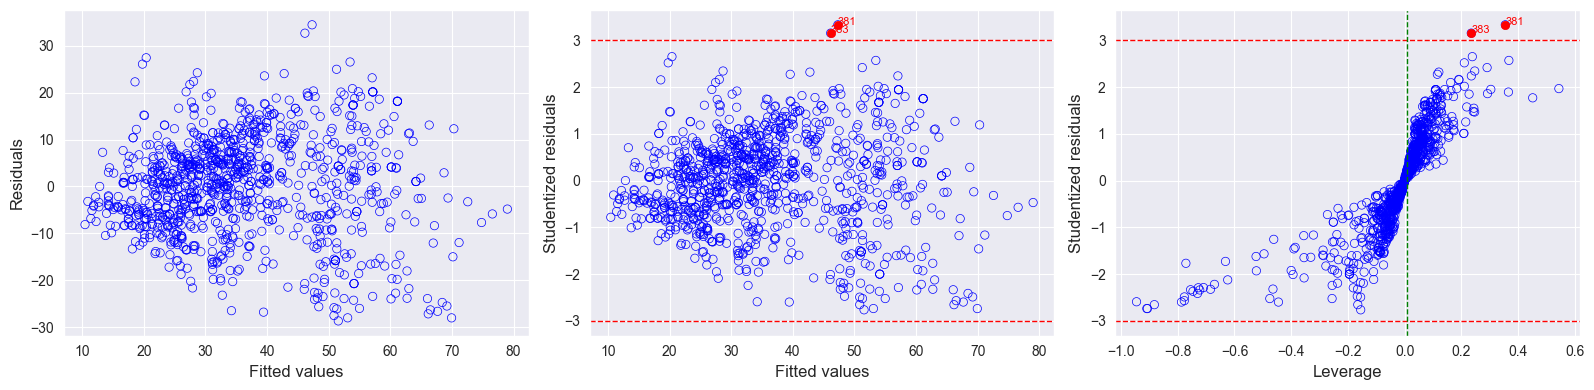

In [14]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1]
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

define model_results_df so that we could append every results from every model into this

In [15]:
columns = ['Model', 'R2', 'Adj_R2', 'MSE', 'RMSE', 'MAE', 'Test_R2', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE']
model_results_df = pd.DataFrame(columns=columns)

Scikit-learn对线性回归进行训练和评估

In [16]:
scaler = StandardScaler()
linear = make_pipeline(scaler, LinearRegression())

results = cross_validate(linear, X_train, y_train, scoring=scoring, cv=kf)

print("===== CV Results =====")
cv_mae = results['test_MAE']
avg_mae = np.abs(np.mean(cv_mae))
print(f"CV MAE: {avg_mae:.4f}")

cv_mse = results['test_MSE']
avg_mse = np.abs(np.mean(cv_mse))
print(f"CV MSE: {avg_mse:.4f}")

cv_rmse = results['test_RMSE']
avg_rmse = np.abs(np.mean(cv_rmse))
print(f"CV RMSE: {avg_rmse:.4f}")

cv_r2 = results['test_R2']
avg_r2 = np.mean(cv_r2)
print(f"CV R2: {avg_r2:.4f}")

cv_adj_r2 = results['test_Adj_R2']
avg_adj_r2 = np.mean(cv_adj_r2)
print(f"CV Adj_R2: {avg_adj_r2:.4f}")


===== CV Results =====
CV MAE: 8.4323
CV MSE: 113.3981
CV RMSE: 10.6371
CV R2: 0.5901
CV Adj_R2: 0.5454


在验证集上测试

In [17]:
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred),
    'Adj_R2': adjusted_r2(y_test, y_pred, p)
}

print("\n===== Test Set Results =====")
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
test_adj_r2 = adjusted_r2(y_test, y_pred, p=X_train.shape[1])
test_mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R2: {test_r2:.4f}")
print(f"Test Adjusted R2: {test_adj_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

new_row = pd.DataFrame([{
    'Model': 'Linear Regression',
    'R2': avg_r2,
    'Adj_R2': avg_adj_r2,
    'MSE': avg_mse,
    'RMSE': avg_rmse,
    'MAE': avg_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': test_adj_r2,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])

if not ((model_results_df['Model'] == 'Linear Regression').any()):
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)
model_results_df



===== Test Set Results =====
Test MSE: 95.6172
Test RMSE: 9.7784
Test R2: 0.6370
Test Adjusted R2: 0.6222
Test MAE: 7.8646


C:\Users\Admin\AppData\Local\Temp\ipykernel_285024\3907797899.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)


,Model,R2,Adj_R2,MSE,RMSE,MAE,Test_R2,Test_Adj_R2,Test_MSE,Test_RMSE,Test_MAE
0,Linear Regression,0.5901,0.545426,113.398084,10.637114,8.432256,0.636961,0.622218,95.617174,9.778403,7.864642


结果不尽人意，尝试多项式回归

Degree 2:
  - Average MSE = 60.9221
  - Average RMSE = 7.7675
  - Average MAE = 5.9618
  - Average R² = 0.7820
  - Average Adjusted R² = 0.7582

Degree 3:
  - Average MSE = 50.4839
  - Average RMSE = 6.8992
  - Average MAE = 4.8100
  - Average R² = 0.8170
  - Average Adjusted R² = 0.7971

Degree 4:
  - Average MSE = 133943.6229
  - Average RMSE = 269.8963
  - Average MAE = 58.6379
  - Average R² = -476.7999
  - Average Adjusted R² = -529.0578


Recommended best degree (balanced): 3
  - Adj R²: 0.7971
  - MSE: 50.4839
  - RMSE: 6.8992
  - MAE: 4.8100
  - R²: 0.8170


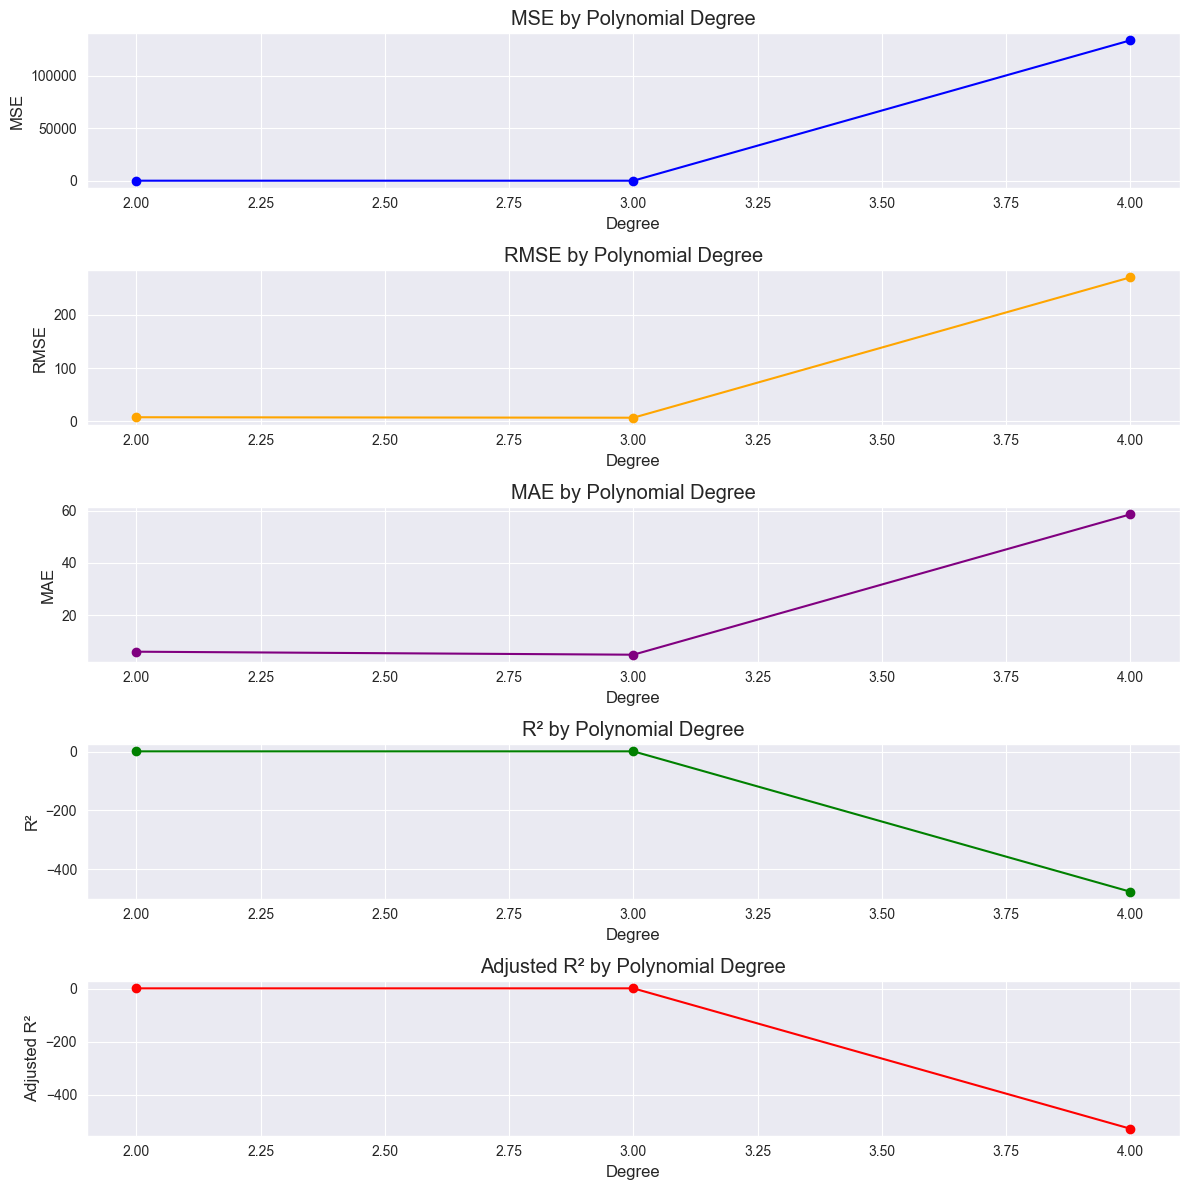

In [18]:
# Try polynomial features with degree 2 to 4
# Store MSE scores for each degree
degree_metrics = {}

# Loop through polynomial degrees from 2 to 4
for degree in range(2, 5):
    model_poly = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])

    scores = cross_validate(model_poly, X_train, y_train, scoring=scoring, cv=kf)

    avg_metrics = {
        'MSE': -np.mean(scores['test_MSE']),  # 转换为正MSE
        'RMSE': -np.mean(scores['test_RMSE']),
        'MAE': -np.mean(scores['test_MAE']),
        'R2': np.mean(scores['test_R2']),
        'Adj_R2': np.mean(scores['test_Adj_R2'])
    }

    degree_metrics[degree] = avg_metrics
    print(f"Degree {degree}:")
    print(f"  - Average MSE = {avg_metrics['MSE']:.4f}")
    print(f"  - Average RMSE = {avg_metrics['RMSE']:.4f}")
    print(f"  - Average MAE = {avg_metrics['MAE']:.4f}")
    print(f"  - Average R² = {avg_metrics['R2']:.4f}")
    print(f"  - Average Adjusted R² = {avg_metrics['Adj_R2']:.4f}")
    print()
    
best_degree_by_adj_r2 = max(degree_metrics, key=lambda d: degree_metrics[d]['Adj_R2'])

# I try to set ajd_r2 as the metrics, if 2 degrees shares the same adj_r2 (difference within 0,01), then we compare MSE.
# Just right here. could change it to another metrics, like first compare MSE and then R2 and something like this.
candidate_degrees = []
for degree in degree_metrics:
    if degree_metrics[degree]['Adj_R2'] >= degree_metrics[best_degree_by_adj_r2]['Adj_R2'] - 0.01:
        candidate_degrees.append(degree)

best_degree = min(candidate_degrees, key=lambda d: degree_metrics[d]['MSE'])
print(f"\nRecommended best degree (balanced): {best_degree}")
print(f"  - Adj R²: {degree_metrics[best_degree]['Adj_R2']:.4f}")
print(f"  - MSE: {degree_metrics[best_degree]['MSE']:.4f}")
print(f"  - RMSE: {degree_metrics[best_degree]['RMSE']:.4f}")
print(f"  - MAE: {degree_metrics[best_degree]['MAE']:.4f}")
print(f"  - R²: {degree_metrics[best_degree]['R2']:.4f}")

degrees = list(degree_metrics.keys())
mse_values = [degree_metrics[d]['MSE'] for d in degrees]
rmse_values = [degree_metrics[d]['RMSE'] for d in degrees]
r2_values = [degree_metrics[d]['R2'] for d in degrees]
adj_r2_values = [degree_metrics[d]['Adj_R2'] for d in degrees]
mae_values = [degree_metrics[d]['MAE'] for d in degrees]

plt.figure(figsize=(12, 12))

plt.subplot(5, 1, 1)
plt.plot(degrees, mse_values, 'o-', color='blue')
plt.title('MSE by Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.grid(True)

plt.subplot(5, 1, 2)
plt.plot(degrees, rmse_values, 'o-', color='orange')
plt.title('RMSE by Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(5, 1, 3)
plt.plot(degrees, mae_values, 'o-', color='purple')
plt.title('MAE by Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(5, 1, 4)
plt.plot(degrees, r2_values, 'o-', color='green')
plt.title('R² by Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('R²')
plt.grid(True)

plt.subplot(5, 1, 5)
plt.plot(degrees, adj_r2_values, 'o-', color='red')
plt.title('Adjusted R² by Polynomial Degree')
plt.xlabel('Degree')
plt.ylabel('Adjusted R²')
plt.grid(True)

plt.tight_layout()
plt.show()

Result on the test set

In [19]:
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit the model with the best polynomial degree
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test_poly_scaled)

# Calculate MSE and R2 for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = adjusted_r2(y_test, y_test_pred, p=X_train_poly.shape[1])
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n=== Test Set Performance ===")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Adjusted R²: {test_adj_r2:.4f}")

new_row = pd.DataFrame([{
    'Model': f'Polynomial Regression {best_degree} degree',
    'R2': degree_metrics[best_degree]['R2'],
    'Adj_R2': degree_metrics[best_degree]['Adj_R2'],
    'MSE': degree_metrics[best_degree]['MSE'],
    'RMSE': degree_metrics[best_degree]['RMSE'],
    'MAE': degree_metrics[best_degree]['MAE'],
    'Test_R2': test_r2,
    'Test_Adj_R2': test_adj_r2,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])

if not (model_results_df['Model'] == f'Polynomial Regression {best_degree} degree').any():
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)
model_results_df


=== Test Set Performance ===
Test MSE: 51.1225
Test RMSE: 7.1500
Test MAE: 4.8167
Test R²: 0.8059
Test Adjusted R²: 0.0295


,Model,R2,Adj_R2,MSE,RMSE,MAE,Test_R2,Test_Adj_R2,Test_MSE,Test_RMSE,Test_MAE
0,Linear Regression,0.590100,0.545426,113.398084,10.637114,8.432256,0.636961,0.622218,95.617174,9.778403,7.864642
1,Polynomial Regression 3 degree,0.816987,0.797068,50.483908,6.899246,4.809977,0.805898,0.029491,51.122475,7.149998,4.816706


由于特征数量过多（164个）而数据量一共只有1030*0.2=206个，导致调整R方特别低！ 所以多项式回归（高维）不选用调整R方做验证集的指标（仅仅作为测试集的指标）

too many features (164), we have only 206 Data in test set. So the test adj R2 is very low. (we dont actually need it in test set)

Forward stepwise selection

In [20]:
def forward_stepwise_selection_mse(X, y, max_features=None):
    n_features = X.shape[1]
    selected = []
    remaining = list(range(n_features))
    best_mse_list = []

    if max_features is None:
        max_features = n_features

    while len(selected) < max_features:
        mse_candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            model = LinearRegression()
            mse = -np.mean(cross_val_score(model, X[:, features], y, scoring='neg_mean_squared_error', cv=kf))
            mse_candidates.append((mse, candidate))

        mse_candidates.sort()
        best_mse, best_candidate = mse_candidates[0]
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_mse_list.append(best_mse)
        # print(f"Selected feature {best_candidate}, current MSE: {best_mse:.4f}")

    return selected, best_mse_list

3 degree

In [ ]:
# polynomial features with degree 3
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

selected_features, mse_list = forward_stepwise_selection_mse(X_train_poly, y_train)
print(selected_features)

In [ ]:
print(len(selected_features))

Ridge

In [ ]:
# define the model
ridgemodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'MSE', # redit the model based on the mse
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
ridgemodel.fit(X_train, y_train)
#print(ridgemodel[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in ridgemodel[2].cv_results_['params']]
mses = [-score for score in ridgemodel[2].cv_results_['mean_test_MSE']]
r2s = ridgemodel[2].cv_results_['mean_test_R2']
maes = [-score for score in ridgemodel[2].cv_results_['mean_test_MAE']]
rmses = [-score for score in ridgemodel[2].cv_results_['mean_test_RMSE']]
adj_r2s = ridgemodel[2].cv_results_['mean_test_Adj_R2']
    
best_model = ridgemodel.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2s)
best_mae = min(maes)
best_rmse = min(rmses)
best_adj_r2 = max(adj_r2s)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2s)]
best_lambda_mae = lambdas[np.argmin(maes)]
best_lambda_rmse = lambdas[np.argmin(rmses)]
best_lambda_adj_r2 = lambdas[np.argmax(adj_r2s)]

print(f"Best alpha regarding mse:{best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2:{best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
print(f"Best alpha regarding mae: {best_lambda_mae:.2f}, with MAE: {best_mae:.2f}")
print(f"Best alpha regarding rmse: {best_lambda_rmse:.2f}, with RMSE: {best_rmse:.2f}")
print(f"Best alpha regarding adj_r2: {best_lambda_adj_r2:.2f}, with Adj_R2: {best_adj_r2:.2f}")
model

In [ ]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

In [ ]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = best_degree),
        Ridge(alpha = lam)
    )
    model.fit(X_train, y_train)
    coefficients.append(model[2].coef_)
    
    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)

ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

In [ ]:
y_test_pred = ridgemodel.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = adjusted_r2(y_test, y_test_pred, p=X_train_poly.shape[1])
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n=== Test Set Performance ===")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Adjusted R²: {test_adj_r2:.4f}")

best_alpha = ridgemodel.named_steps['gridsearchcv'].best_estimator_.alpha
best_index = ridgemodel.named_steps['gridsearchcv'].best_index_

new_row = pd.DataFrame([{
    'Model': f'Ridge (alpha={best_alpha:.4f})',
    'R2': r2s[best_index],
    'Adj_R2': adj_r2s[best_index],
    'MSE': mses[best_index],
    'RMSE': rmses[best_index],
    'MAE': maes[best_index],
    'Test_R2': test_r2,
    'Test_Adj_R2': test_adj_r2,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])

if not (model_results_df['Model'] == f'Ridge (alpha={best_alpha:.4f})').any():
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

Lasso

In [ ]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree, interaction_only=False, include_bias=False),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 1e-4),
        param_grid={'alpha': np.logspace(-3, 1.5, 50)},
        scoring=scoring,
        refit='MSE',
        cv=kf
    )
)

# Fit the pipeline
lassomodel.fit(X_train, y_train)
#print(lassomodel[2].cv_results_)

# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses_lasso = [-score for score in grid.cv_results_['mean_test_MSE']]  # convert from negative MSE
r2_lasso = grid.cv_results_['mean_test_R2']
maes_lasso = [-score for score in grid.cv_results_['mean_test_MAE']]
rmses_lasso = [-score for score in grid.cv_results_['mean_test_RMSE']]
adj_r2s_lasso = grid.cv_results_['mean_test_Adj_R2']

# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses_lasso)
best_lassor2 = max(r2_lasso)
best_mae = min(maes_lasso)
best_rmse = min(rmses_lasso)
best_adj_r2 = max(adj_r2s_lasso)

best_lambda_mse_lasso = lassolambdas[np.argmin(mses_lasso)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2_lasso)]
best_lambda_mae = lassolambdas[np.argmin(maes_lasso)]
best_lambda_rmse = lassolambdas[np.argmin(rmses_lasso)]
best_lambda_adj_r2 = lassolambdas[np.argmax(adj_r2s_lasso)]

print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.3f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.3f}, with R2: {best_lassor2:.3f}")
print(f"Best alpha regarding MAE: {best_lambda_mae:.3f}")
print(f"Best alpha regarding RMSE: {best_lambda_rmse:.3f}")
print(f"Best alpha regarding Adjusted R2: {best_lambda_adj_r2:.3f}")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lassolambdas, mses_lasso, label='MSE')
ax.plot(lassolambdas, maes_lasso, label='MAE')
ax.plot(lassolambdas, rmses_lasso, label='RMSE')
ax.set_xscale('log')
ax.set_xlabel(r'Hyper-parameter $\lambda$')
ax.set_ylabel('Error Metrics')
ax.set_title('Error Metrics vs Lambda for Lasso Regression')
ax.legend()
ax.grid(True)
plt.show()


In [ ]:
y_test_pred = lassomodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_adj_r2 = adjusted_r2(y_test, y_test_pred, p=X_train_poly.shape[1])
print(f"Test MSE: {test_mse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R2: {test_r2:.2f}")
print(f"Test adjusted R2: {test_adj_r2:.2f}")


best_index = np.argmin(mses_lasso)
best_alpha = lassolambdas[best_index]

new_row = pd.DataFrame([{
    'Model': f'Lasso (alpha={best_alpha:.4f})',
    'R2': r2s[best_index],
    'Adj_R2': adj_r2s[best_index],
    'MSE': mses[best_index],
    'RMSE': rmses[best_index],
    'MAE': maes[best_index],
    'Test_R2': test_r2,
    'Test_Adj_R2': test_adj_r2,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])

if not (model_results_df['Model'] == f'Lasso (alpha={best_alpha:.4f})').any():
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

None 0 Coeff

In [ ]:
feature_names = [f"x{i}" for i in range(X.shape[1])]

# Extract from the fitted polynomial step
poly = lassomodel.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(input_features=X.columns if hasattr(X, 'columns') else None)

print("Expanded feature names:", feature_names)

# Get final fitted Lasso model
lasso = lassomodel.named_steps['gridsearchcv'].best_estimator_

# Get coefficients
coefs = lasso.coef_

# Combine with feature names
used_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef != 0]
zero_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef == 0]

print("Non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("Total features:", len(lasso.coef_))
print("Zero coefficients:", zero_features)

lasso_weights = pd.Series(coefs, index=feature_names)
lasso_weights.sort_values(key=abs, ascending=False)  # sort by absolute value

只有一个 coefficient x0 x2 is set to zero, but there are many features that are close to zero, which means that they are probably not important for the model. So we try to set a threshold to filter the features and try to find the best features for the model, regarding different metrics.

In [ ]:
# Polynomial features transformation
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(feature_columns)

# Scale the features and apply polynomial transformation
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Define the Lasso model with GridSearchCV
best_lasso = grid.best_estimator_
coefs = pd.Series(best_lasso.coef_, index=feature_names)

# Thresholds for feature selection
thresholds = np.linspace(0, 2.5, 50)  # 50 thresholds from 0 to 2.5

# Store results
results = []

for threshold in thresholds:
    selected = coefs[np.abs(coefs) >= threshold]
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected.index]

    if len(selected_indices) == 0:
        continue  # skip if no features are selected

    X_train_selected = X_train_poly_scaled[:, selected_indices]
    X_test_selected = X_test_poly_scaled[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    # Train and test scores
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_adj_r2 = adjusted_r2(y_test, y_test_pred, p=X_train_poly_scaled.shape[1])

    results.append({
        "threshold": threshold,
        "n_features": len(selected_indices),
        "train r2": train_r2,
        "test r2": test_r2,

        "train adjusted r2": train_adj_r2,

        "train mse": train_mse,
        "test mse": test_mse,

        "train mae": train_mae,
        "test mae": test_mae,

        "train rmse": train_rmse,
        "test rmse": test_rmse,
        
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# print(results_df)

#  find the best threshold based on test R²
best_row = results_df.loc[results_df['test r2'].idxmax()]
print("\nBest Threshold (by R²):")
print(best_row)


plt.figure(figsize=(18, 10))

# R²
plt.subplot(2, 2, 1)
plt.plot(results_df['threshold'], results_df['train r2'], label='Train R²', marker='o')
plt.plot(results_df['threshold'], results_df['test r2'], label='Test R²', marker='s')
plt.xlabel('Threshold')
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Threshold')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(2, 2, 2)
plt.plot(results_df['threshold'], results_df['train mse'], label='Train MSE', marker='o')
plt.plot(results_df['threshold'], results_df['test mse'], label='Test MSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE by Threshold')
plt.legend()
plt.grid(True)

# MAE
plt.subplot(2, 2, 3)
plt.plot(results_df['threshold'], results_df['train mae'], label='Train MAE', marker='o')
plt.plot(results_df['threshold'], results_df['test mae'], label='Test MAE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Absolute Error')
plt.title('Train vs Test MAE by Threshold')
plt.legend()
plt.grid(True)

# RMSE
plt.subplot(2, 2, 4)
plt.plot(results_df['threshold'], results_df['train rmse'], label='Train RMSE', marker='o')
plt.plot(results_df['threshold'], results_df['test rmse'], label='Test RMSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Root Mean Squared Error')
plt.title('Train vs Test RMSE by Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# calculate the R² and MSE gap
results_df['r2 gap'] = np.abs(results_df['train r2'] - results_df['test r2'])
results_df['mse gap'] = np.abs(results_df['train mse'] - results_df['test mse'])
results_df['mae gap'] = np.abs(results_df['train mae'] - results_df['test mae'])
results_df['rmse gap'] = np.abs(results_df['train rmse'] - results_df['test rmse'])

# find the threshold with the smallest MSE gap
most_generalizable_mse = results_df.loc[results_df['mse gap'].idxmin()]
most_generalizable_mae = results_df.loc[results_df['mae gap'].idxmin()]
most_generalizable_rmse = results_df.loc[results_df['rmse gap'].idxmin()]

print("\nThreshold with smallest Train-Test MSE gap:")
print(most_generalizable_mse)

print("\nThreshold with smallest Train-Test MAE gap:")
print(most_generalizable_mae)

print("\nThreshold with smallest Train-Test RMSE gap:")
print(most_generalizable_rmse)

决策树

In [ ]:
# os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [ ]:
#Fit a regression tree on the training data using the mse metric for splitting, considering all the features and splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(criterion='squared_error', max_features=None, min_samples_split=20)

tree_est = tree.fit(X_train, y_train)

In [ ]:
#Visualize the tree with the help of the graphviz and the iPython package
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=concrete_df.columns[0:-1],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

预测并评估

In [ ]:
# test on the train set (to do comparation)
y_pred_train = tree_est.predict(X_train)  
train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
print("R² Score on Train Set:", train_r2)
print("Mean Squared Error on train set:", train_mse)
print("Mean Absolute Error on train set:", train_mae)
print("Root Mean Squared Error on train set:", train_rmse)

In [ ]:
y_pred = tree_est.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("R² Score on Test Set:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Decision Tree basic',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse,
    'Test_RMSE': rmse,
    'Test_MAE': mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Decision Tree basic').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

优化模型
特征重要性图


In [ ]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances.sort_values(axis=0, ascending=False)

In [ ]:
importances = tree_est.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
# plt.bar(range(len(importances)), importances[indices], align="center")
# plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.barh(range(len(importances)), importances[indices], align="center")
plt.yticks(range(len(importances)), feature_names[indices])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.close() 


超参数优化

In [ ]:
# Define the model
tree = DecisionTreeRegressor(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=kf,                # 10-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    n_jobs=-1,           # Use all CPU cores
    verbose=1            # Print progress
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for prediction
best_tree = grid_search.best_estimator_

# test on the train set (to do comparation)

y_pred_train = best_tree.predict(X_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
print("R² Score on Train Set:", train_r2)
print("Mean Squared Error on train set:", train_mse)
print("Mean Absolute Error on train set:", train_mae)
print("Root Mean Squared Error on train set:", train_rmse)

# Predict on test set
y_pred = best_tree.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Test set MSE: {mse:.4f}")
print(f"Test set MAE: {mae:.4f}")
print(f"Test set RMSE: {rmse:.4f}")
print(f"Test set R²: {r2:.4f}")

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Decision Tree Hyper',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse,
    'Test_RMSE': rmse,
    'Test_MAE': mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Decision Tree Hyper').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

In [ ]:
# 1. Train the optimized tree
optimized_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=0
)
optimized_tree.fit(X_train, y_train)

# 2. Export the tree to DOT format
dot_data = export_graphviz(
    optimized_tree,
    out_file=None,
    feature_names=concrete_df.columns[:-1],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render and display using graphviz
graph = graphviz.Source(dot_data, format='png')
Image(graph.render('optimized_tree'))


Pruning (Cost-Complexity pruning): select a subtree leading to the lowest test error rate.

Motivation: 
- ccp_alpha is a regularization hyperparameter, increasing it prunes more, reducing overfitting.
- We have already got a strong performance (R² ≈ 0.8055), and pruning it can imporve generalization further.

In [ ]:
# Fit a full tree
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Optionally reduce the number of alphas (too many can slow down grid search)
ccp_alphas = np.unique(np.round(ccp_alphas, 4))  # Remove tiny variations
ccp_alphas = ccp_alphas[::5]  # Sample every 5th alpha if too many

In [ ]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': ccp_alphas  # ← added
}

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


In [ ]:
#Evaluate and visualize
print("Best parameters:", grid.best_params_)

best_tree = grid.best_estimator_

# test on the train set (to do comparation)

y_pred_train = best_tree.predict(X_train)

train_r2 = r2_score(y_train, y_pred_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
print("R² Score on Train Set:", train_r2)
print("Mean Squared Error on train set:", train_mse)
print("Mean Absolute Error on train set:", train_mae)
print("Root Mean Squared Error on train set:", train_rmse)

y_pred = best_tree.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Test set MSE: {mse:.4f}")
print(f"Test set MAE: {mae:.4f}")
print(f"Test set RMSE: {rmse:.4f}")
print(f"Test set R²: {r2:.4f}")

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Decision Tree Pruning',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse,
    'Test_RMSE': rmse,
    'Test_MAE': mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Decision Tree Pruning').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

Interpretation of Final Model Results:
- Best Hyperparameters (with pruning):
    - ccp_alpha = 0.0689
    - max_depth = 10
    - max_features: None
    - min_samples_leaf = 1
    - min_samples_spilit = 2
- Test Set Performance:
    - MSE: ≈ 56.2, which is still very low
    - R²: ≈ 0.787, it is still very solid fit (explains ~78.7% of variance)
- Pruning Effect:
    - The ccp_alpha = 0.0689 suggests aggressive pruning helped generalize better.
    - The earlier R² was ≈ 0.7815 without pruning, so pruning leads to a higher R² and a **simpler, more generalizable tree**.



Pruned tree plot

In [ ]:
# 1. Fit the optimized and pruned tree
final_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    ccp_alpha=0.2008,
    random_state=0
)
final_tree.fit(X_train, y_train)

# 2. Export to DOT format
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns if hasattr(X, 'columns') else [f"X{i}" for i in range(X.shape[1])],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render with graphviz
tree_graph = graphviz.Source(dot_data, format="png")
tree_graph.render("final_pruned_tree", cleanup=True)
Image("final_pruned_tree.png")

Model Evaluation & Diagonistic Checking

Residual Analysis (difference between actual and predicted values)

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Parity Plot (checks how close predictions are to actual values)

In [ ]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

Model Complexity Check - check if the tree is too deep or has too many leaves. A very large tree usually overfits.

In [ ]:

print("Tree depth:", final_tree.get_depth())
print("Number of leaves:", final_tree.get_n_leaves())

过拟合测试

In [ ]:
# Predictions
y_train_pred = final_tree.predict(X_train)
y_test_pred = final_tree.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Decision Tree Final',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Decision Tree Final').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

Interpretation:

The model fits the training data very well but is less accurate on new data, indicating some degree of overfitting, but not severe.

The gap between train and test metrics has reduced compared to the previous attempts, so this model generalizes better.

确定最优树数量

In [ ]:
for n in [50, 100, 150, 200,250, 300, 500]:
    model = RandomForestRegressor(n_estimators=n, random_state=0, oob_score=True)
    model.fit(X_train, y_train)
    print(f"{n} trees - OOB Score: {model.oob_score_:.4f}")


from the result, we can see that the OOB Score of 200 trees is the best, which means it saves training time and is more efficient. Then perform by buding a bagged ensemble using 200 trees.

In [ ]:
bagger = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',         
    bootstrap=True,
    oob_score=True,
    random_state=0
)

bag_est = bagger.fit(X_train, y_train)
y_pred = bag_est.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("Test MSE = ", test_mse)
print("Test RMSE = ", test_rmse)
print("Test MAE = ", test_mae)
print("Test R² = ", test_r2)
print("OOB Score = ", bag_est.oob_score_)

In [ ]:
y_pred_train = bag_est.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print("Train MSE = ", train_mse)
print("Train RMSE = ", train_rmse)
print("Train MAE = ", train_mae)
print("Train R² = ", train_r2)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Random Forest Basic',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Random Forest Basic').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

结果可视化

In [ ]:
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

plt.show()


限制特征数量的随机森林

In [ ]:
forest = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features=4, 
                               bootstrap=True, oob_score=True, random_state=0)

forest_est = forest.fit(X_train, y_train)
y_pred = forest_est.predict(X_test)

test_r2 = r2_score(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("Test MSE = ", test_mse)
print("Test RMSE = ", test_rmse)
print("Test MAE = ", test_mae)
print("Test R² = ", test_r2)
print("OOB Score = ", forest_est.oob_score_)

In [ ]:
y_pred_train = forest_est.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print("Train MSE = ", train_mse)
print("Train RMSE = ", train_rmse)
print("Train MAE = ", train_mae)
print("Train R² = ", train_r2)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Random Forest feature selection',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Random Forest feature selection').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

特征重要性分析

In [ ]:
feature_importances = pd.Series(data=forest_est.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances = feature_importances.sort_values(axis=0, ascending=False)

feature_importances

In [ ]:
feature_importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title('Feature Importances')
plt.xlabel('Importance Score')

基于特征选择的简化模型

In [ ]:
# List of all feature names in order, matching X_train columns
feature_names = [
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 
    'Fly Ash (component 3)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)', 
    'Age (day)'
]

# Top features to keep
top_features = [
    'Age (day)', 
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

# Get their column indices
top_indices = [feature_names.index(f) for f in top_features]

# Select columns by index
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_test[:, top_indices]

# Train the model on reduced features
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
test_mse = mean_squared_error(y_test, y_pred_reduced)
test_rmse = root_mean_squared_error(y_test, y_pred_reduced)
test_r2 = r2_score(y_test, y_pred_reduced)
test_mae = mean_absolute_error(y_test, y_pred_reduced)
print("Test MSE = ", test_mse)
print("Test RMSE = ", test_rmse)
print("Test MAE = ", test_mae)
print("Test R² = ", test_r2)

In [ ]:
y_pred_train_reduced = model_reduced.predict(X_train_reduced)
train_mse = mean_squared_error(y_train, y_pred_train_reduced)
train_rmse = root_mean_squared_error(y_train, y_pred_train_reduced)
train_r2 = r2_score(y_train, y_pred_train_reduced)
train_mae = mean_absolute_error(y_train, y_pred_train_reduced)
print("Train MSE = ", train_mse)
print("Train RMSE = ", train_rmse)
print("Train MAE = ", train_mae)
print("Train R² = ", train_r2)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Random Forest Top 5 features',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Random Forest Top 5 features').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

超参数调优

In [ ]:
# Define the model
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Define the parameter grid to search
param_grid = {
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("Test MSE = ", test_mse)
print("Test RMSE = ", test_rmse)
print("Test MAE = ", test_mae)
print("Test R² = ", test_r2)

In [ ]:
y_pred_train = best_rf.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

print("Train MSE = ", train_mse)
print("Train RMSE = ", train_rmse)
print("Train MAE = ", train_mae)
print("Train R² = ", train_r2)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Random Forest tuned',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Random Forest tuned').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

残差分析

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.axvline(x=0, color='r')

OOB 分数验证

In [ ]:
# Re-train model with OOB enabled
rf_oob = RandomForestRegressor(n_estimators=200, max_depth=best_rf.max_depth,
                               max_features=best_rf.max_features,
                               random_state=0, oob_score=True)
rf_oob.fit(X_train, y_train)

print(f"OOB R² score: {rf_oob.oob_score_:.4f}")


#### 3. Gradient Boosting Model

In [ ]:

booster = GradientBoostingRegressor(
    loss='squared_error',        
    learning_rate=0.01,          
    n_estimators=200,            
    max_depth=3,                 
    random_state=0               
)

boost_est = booster.fit(X_train, y_train)
y_pred = boost_est.predict(X_test)

y_pred_train = boost_est.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = root_mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

y_pred_test = boost_est.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = root_mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAE:", train_mae)
print("Train R²:", train_r2)

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAE:", test_mae)
print("Test R²:", test_r2)

In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting basic',
    'R2': train_r2,
    'Adj_R2': np.nan,
    'MSE': train_mse,
    'RMSE': train_rmse,
    'MAE': train_mae,
    'Test_R2': test_r2,
    'Test_Adj_R2': np.nan,
    'Test_MSE': test_mse,
    'Test_RMSE': test_rmse,
    'Test_MAE': test_mae
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Gradient Boosting basic').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

特征重要性分析

In [ ]:
feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(concrete_df.columns[:-1]))
sorted_feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sorted_feature_importances.iloc[::-1].plot(kind='barh')
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

部分依赖图（PDP）分析

In [ ]:
feature_idxs = np.argsort(feature_importances.values)[-3:]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    boost_est, X_train, features=feature_idxs,
    feature_names=feature_importances.index.tolist(), ax=ax
)
plt.tight_layout()
plt.show()

基于特征选择的模型优化

In [ ]:
important_features = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)',
    'Water  (component 4)(kg in a m^3 mixture)',
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

X_selected = concrete_df[important_features]
y = concrete_df['Concrete compressive strength(MPa, megapascals)'] 

booster_sel = GradientBoostingRegressor(
    loss='squared_error',        # corrected here
    learning_rate=0.001,
    n_estimators=5000,
    max_depth=4,
    random_state=0
)

boost_est_sel = booster_sel.fit(X_train, y_train)

y_train_pred_sel = boost_est_sel.predict(X_train)
y_test_pred_sel = boost_est_sel.predict(X_test)

# Train metrics
mse_train_sel = mean_squared_error(y_train, y_train_pred_sel)
rmse_train_sel = root_mean_squared_error(y_train, y_train_pred_sel)
r2_train_sel = r2_score(y_train, y_train_pred_sel)
mae_train_sel = mean_absolute_error(y_train, y_train_pred_sel)

# Test metrics
mse_test_sel = mean_squared_error(y_test, y_test_pred_sel)
rmse_test_sel = root_mean_squared_error(y_test, y_test_pred_sel)
r2_test_sel = r2_score(y_test, y_test_pred_sel)
mae_test_sel = mean_absolute_error(y_test, y_test_pred_sel)

# Overfit gap
overfit_gap_sel = r2_train_sel - r2_test_sel

print(f"Overfit gap: {overfit_gap_sel:.3f}")
print(f"Train R²: {r2_train_sel:.3f}, Test R²: {r2_test_sel:.3f}")
print(f"Train MSE: {mse_train_sel:.3f}, Test MSE: {mse_test_sel:.3f}")
print(f"Train RMSE: {rmse_train_sel:.3f}, Test RMSE: {rmse_test_sel:.3f}")
print(f"Train MAE: {mae_train_sel:.3f}, Test MAE: {mae_test_sel:.3f}")


In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting 5 Features',
    'R2': r2_train_sel,
    'Adj_R2': np.nan,
    'MSE': mse_train_sel,
    'RMSE': rmse_train_sel,
    'MAE': mae_train_sel,
    'Test_R2': r2_test_sel,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse_test_sel,
    'Test_RMSE': rmse_test_sel,
    'Test_MAE': mae_test_sel
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Gradient Boosting 5 Features').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

早停的梯度提升

In [ ]:
# Select features strongly supported by PDP interpretation
important_features_pdp = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)'
]

X_selected_pdp = concrete_df[important_features_pdp]
y = concrete_df['Concrete compressive strength(MPa, megapascals)']


# Set up the gradient boosting regressor with early stopping
booster_sel = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,      
    n_estimators=1000,       
    max_depth=4,
    random_state=0,
    validation_fraction=0.1, 
    n_iter_no_change=50,  
    tol=1e-4
)

# Fit model with early stopping
boost_est_sel = booster_sel.fit(X_train, y_train)

# Predictions and evaluation
y_train_pred = boost_est_sel.predict(X_train)
y_test_pred = boost_est_sel.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

overfit_gap = r2_train - r2_test

print("Train MSE with PDP-based selected features:", mse_train)
print("Train RMSE with PDP-based selected features:", rmse_train)
print("Train MAE with PDP-based selected features:", mae_train)
print("Train R² with PDP-based selected features:", r2_train)

print("Test MSE with PDP-based selected features:", mse_test)
print("Test RMSE with PDP-based selected features:", rmse_test)
print("Test MAE with PDP-based selected features:", mae_test)
print("Test R² with PDP-based selected features:", r2_test)

print(f"Overfit gap (Train R² - Test R²): {overfit_gap:.4f}")


In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting PDP 3 Features',
    'R2': r2_train,
    'Adj_R2': np.nan,
    'MSE': mse_train,
    'RMSE': rmse_train,
    'MAE': mae_train,
    'Test_R2': r2_test,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse_test,
    'Test_RMSE': rmse_test,
    'Test_MAE': mae_test
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Gradient Boosting PDP 3 Features').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

随即搜索超参数调优

In [ ]:
# Define the model
gbr = GradientBoostingRegressor(random_state=0)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    cv=kf,                
    scoring='neg_mean_squared_error',  # minimize MSE
    n_jobs=-1,           # use all cores
    random_state=0,
    verbose=1
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_booster = random_search.best_estimator_

# Predict on test data
y_train_pred = best_booster.predict(X_train)
y_test_pred = best_booster.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

overfit_gap = r2_train - r2_test

print(f"Best parameters: {random_search.best_params_}")
print("Train MSE:", mse_train)
print("Train RMSE:", rmse_train)
print("Train MAE:", mae_train)
print("Train R²:", r2_train)

print("Test MSE:", mse_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)
print("Test R²:", r2_test)

print(f"Overfit gap (Train R² - Test R²): {overfit_gap:.4f}")


In [ ]:
# append

new_row = pd.DataFrame([{
    'Model': 'Gradient Boosting Best Booster',
    'R2': r2_train,
    'Adj_R2': np.nan,
    'MSE': mse_train,
    'RMSE': rmse_train,
    'MAE': mae_train,
    'Test_R2': r2_test,
    'Test_Adj_R2': np.nan,
    'Test_MSE': mse_test,
    'Test_RMSE': rmse_test,
    'Test_MAE': mae_test
}])


if 'Model' in model_results_df.columns and not model_results_df.empty:
    model_exists = (model_results_df['Model'] == 'Gradient Boosting Best Booster').any()
else:
    model_exists = False

if not model_exists:
    model_results_df = pd.concat([model_results_df, new_row], ignore_index=True)

model_results_df

残差分析

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residual Distribution')

plt.subplot(1, 2, 2)
plt.boxplot(residuals, vert=False)
plt.title('Residual Boxplot')

plt.tight_layout()
plt.show()

In [ ]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()
plt.close()

Why is here model.predict? It show actually the result of random forest tuned. 

In [ ]:
# # Predictions
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

# # R²
# r2_train = r2_score(y_train, y_train_pred)
# r2_test = r2_score(y_test, y_test_pred)

# # RMSE
# rmse_train = root_mean_squared_error(y_train, y_train_pred)
# rmse_test =root_mean_squared_error(y_test, y_test_pred)

# mae_train = mean_absolute_error(y_train, y_train_pred)
# mae_test = mean_absolute_error(y_test, y_test_pred)

# mse_train = mean_squared_error(y_train, y_train_pred)
# mse_test = mean_squared_error(y_test, y_test_pred)

# overfit_gap = r2_train - r2_test

# print(f"overfit gap: {overfit_gap:.3f} ")
# print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
# print(f"Train MSE: {mse_train:.3f}, Test MSE: {mse_test:.3f}")
# print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")
# print(f"Train MAE: {mae_train:.3f}, Test MAE: {mae_test:.3f}")

Validation

In [ ]:
# Set global style
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.dpi'] = 100

# Calculate performance gaps
model_results_df['R2_Gap'] = model_results_df['R2'] - model_results_df['Test_R2']
model_results_df['MSE_Ratio'] = model_results_df['Test_MSE'] / model_results_df['MSE']

model_results_df

Test R2 Comparison

In [ ]:
plt.figure(figsize=(10, 8))
sorted_df = model_results_df.sort_values("Test_R2", ascending=True)
ax = sns.barplot(x="Test_R2", y="Model", data=sorted_df, color="royalblue")
plt.title("Model Comparison by Test R² Score", fontsize=16)
plt.xlabel("Test R²", fontsize=12)
plt.ylabel("")
plt.xlim(0, 1)

# Add value labels
for i, v in enumerate(sorted_df["Test_R2"]):
    ax.text(v + 0.02, i, f"{v:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

Overfitting

In [ ]:
plt.figure(figsize=(10, 8))
gap_sorted = model_results_df.sort_values("R2_Gap", ascending=True)
ax = sns.barplot(x="R2_Gap", y="Model", data=gap_sorted, color="coral")
plt.axvline(0, color='k', linestyle='--', alpha=0.7)
plt.title("Train-Test R² Gap (Overfitting Indicator)", fontsize=16)
plt.xlabel("R² Gap (Train - Test)", fontsize=12)
plt.ylabel("")

# Add value labels
for i, v in enumerate(gap_sorted["R2_Gap"]):
    ax.text(v + 0.01 if v > 0 else v - 0.1, i, f"{v:.3f}", 
            va="center", fontsize=10, 
            color='red' if v > 0.15 else 'black')

plt.tight_layout()
plt.show()

MSE Comparison

In [ ]:
plt.figure(figsize=(10, 8))

mse_sorted = model_results_df.sort_values("Test_MSE", ascending=False)

ax = sns.barplot(x="Test_MSE", y="Model", data=mse_sorted, color="mediumseagreen")
plt.title("Model Comparison by Test MSE", fontsize=16)
plt.xlabel("Test MSE", fontsize=12)
plt.ylabel("")

for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    height = bar.get_height()
    x = bar.get_x() + width
    y = bar.get_y() + height/2
    
    ax.text(x + 0.5, y, f"{width:.1f}", 
            va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.show()

RMSE Comparison

In [ ]:
plt.figure(figsize=(10, 8))
rmse_sorted = model_results_df.sort_values("Test_RMSE", ascending=False)
ax = sns.barplot(x="Test_RMSE", y="Model", data=rmse_sorted, color="mediumseagreen")
plt.title("Model Comparison by Test RMSE", fontsize=16)
plt.xlabel("Test RMSE", fontsize=12)
plt.ylabel("")

# Add value labels
for i, v in enumerate(rmse_sorted["Test_RMSE"]):
    ax.text(v + 0.1, i, f"{v:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

Performance Consistency

In [ ]:
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(x="R2", y="Test_R2", 
                     size="MSE_Ratio",
                     sizes=(50, 200),
                     hue="Model",
                     data=model_results_df,
                     alpha=0.8,
                     legend=False)

# Add reference line
max_val = max(model_results_df[["R2", "Test_R2"]].max().max(), 1)
plt.plot([0, max_val], [0, max_val], "r--", alpha=0.7)
plt.fill_between([0, max_val], [0, max_val], [max_val, max_val], 
                 color="red", alpha=0.05)

# Add labels
for i, row in model_results_df.iterrows():
    plt.annotate(row["Model"], 
                 (row["R2"] + 0.005, row["Test_R2"] + 0.005), 
                 fontsize=9)

plt.title("Train vs Test R² Performance", fontsize=16)
plt.xlabel("Train R²", fontsize=12)
plt.ylabel("Test R²", fontsize=12)
plt.xlim(0.5, 1.05)
plt.ylim(0.5, 1.05)

plt.tight_layout()
plt.show()

Performance Summary Table

In [ ]:
# Create performance summary
summary_df = model_results_df[[
    "Model", "Test_R2", "Test_MSE", "Test_RMSE", "Test_MAE", "R2_Gap", "MSE_Ratio"
]].copy()

# Add warnings
def add_warnings(row):
    warnings = []
    if row["R2_Gap"] > 0.15: 
        warnings.append("High overfitting")
    if row["MSE_Ratio"] > 2.5:
        warnings.append("High MSE inflation")
    if row["Test_MSE"] > 50:  
        warnings.append(f"High abs MSE ({row['Test_MSE']:.1f})")
    return ", ".join(warnings) if warnings else "-"

summary_df["Warnings"] = summary_df.apply(add_warnings, axis=1)

# Sort by Test_R2
summary_df = summary_df.sort_values("Test_R2", ascending=False)

# Format metrics
summary_df["Test_R2"] = summary_df["Test_R2"].map("{:.3f}".format)
summary_df["Test_MSE"] = summary_df["Test_MSE"].map("{:.1f}".format)
summary_df["Test_RMSE"] = summary_df["Test_RMSE"].map("{:.3f}".format)
summary_df["Test_MAE"] = summary_df["Test_MAE"].map("{:.3f}".format)
summary_df["R2_Gap"] = summary_df["R2_Gap"].map("{:.3f}".format)
summary_df["MSE_Ratio"] = summary_df["MSE_Ratio"].map("{:.2f}".format)

print("Model Performance Summary")
print(summary_df.to_string(index=False))

Report

In [ ]:
# Identify best model
best_model = model_results_df.loc[model_results_df["Test_R2"].idxmax()]

# Identify high-risk models
high_risk = model_results_df[model_results_df["R2_Gap"] > 0.15]

columns = ["Model", "Test_R2", "Test_RMSE", "Test_MAE", "R2_Gap"]

print("MODEL VALIDATION REPORT")
print(f"Top Performing Model: {best_model[columns[0]]}")
print(f"  Test R²: {best_model[columns[1]]:.3f}")
print(f"  Test RMSE: {best_model[columns[2]]:.3f}")
print(f"  Test MAE: {best_model[columns[3]]:.3f}")
print(f"  R² Gap: {best_model[columns[4]]:.3f}")

if not high_risk.empty:
    print("\n High Overfitting Risk Models:")
    for _, row in high_risk.iterrows():
        print(f"  - {row['Model']}: R² Gap = {row['R2_Gap']:.3f} (Train: {row['R2']:.3f}, Test: {row['Test_R2']:.3f})")


print("1. Prioritize Gradient Boosting Best Booster for production deployment")
print("2. Investigate overfitting in Decision Tree models (Hyper, Pruning) and Polynomial Regression")
print("3. Validate Gradient Boosting Best Booster on new unseen data")
print("4. Compare feature importance between top Gradient Boosting and Random Forest models")
print("5. We could spilt data into train, test and validation set")